In [1]:

from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)


# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 0

seg_exper_handler = seg_exper_ensemble.seg_exper_handlers[TEST_FOLD]
seg_exper_handler.get_test_set()

  0%|          | 0/25 [00:00<?, ?it/s]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 

100%|██████████| 25/25 [00:01<00:00, 14.18it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


In [3]:
type_of_map = "e_map"
list_with_patients = ["patient018", "patient056", "patient098", "patient100"]
seg_exper_ensemble.prepare_handlers(patient_ids=list_with_patients, type_of_map=type_of_map, force_reload=True)

In [49]:
from utils.detector.generate_dt_maps import generate_dt_maps

_ = generate_dt_maps(seg_exper_handler, patient_id=patient_id)
    

In [4]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, \
    generate_binary_structure
    
def auto_pred_border(reference, connectivity=1):
    reference = np.atleast_1d(reference.astype(np.bool))
    # binary structure
    footprint = generate_binary_structure(reference.ndim, connectivity)
    if 0 == np.count_nonzero(reference):
        raise RuntimeError('The reference array does not contain any binary object.')

    reference_border = np.logical_xor(reference, binary_erosion(reference, structure=footprint, iterations=1))
    return reference_border

In [6]:
from utils.detector.generate_dt_maps import determine_target_voxels

target_rois = {}
for p_id in list_with_patients:
    print("{}".format(p_id))
    _, labels = seg_exper_handler.test_set.get_test_pair(p_id)
    dt_slices = seg_exper_handler.get_dt_maps(p_id)
    auto_pred = seg_exper_handler.pred_labels[p_id]
    umap = seg_exper_handler.entropy_maps[p_id]
    target_rois[p_id] = determine_target_voxels(auto_pred, labels, umap, dt_slices, map_threshold=0.1)

patient018
patient056
patient098
patient100


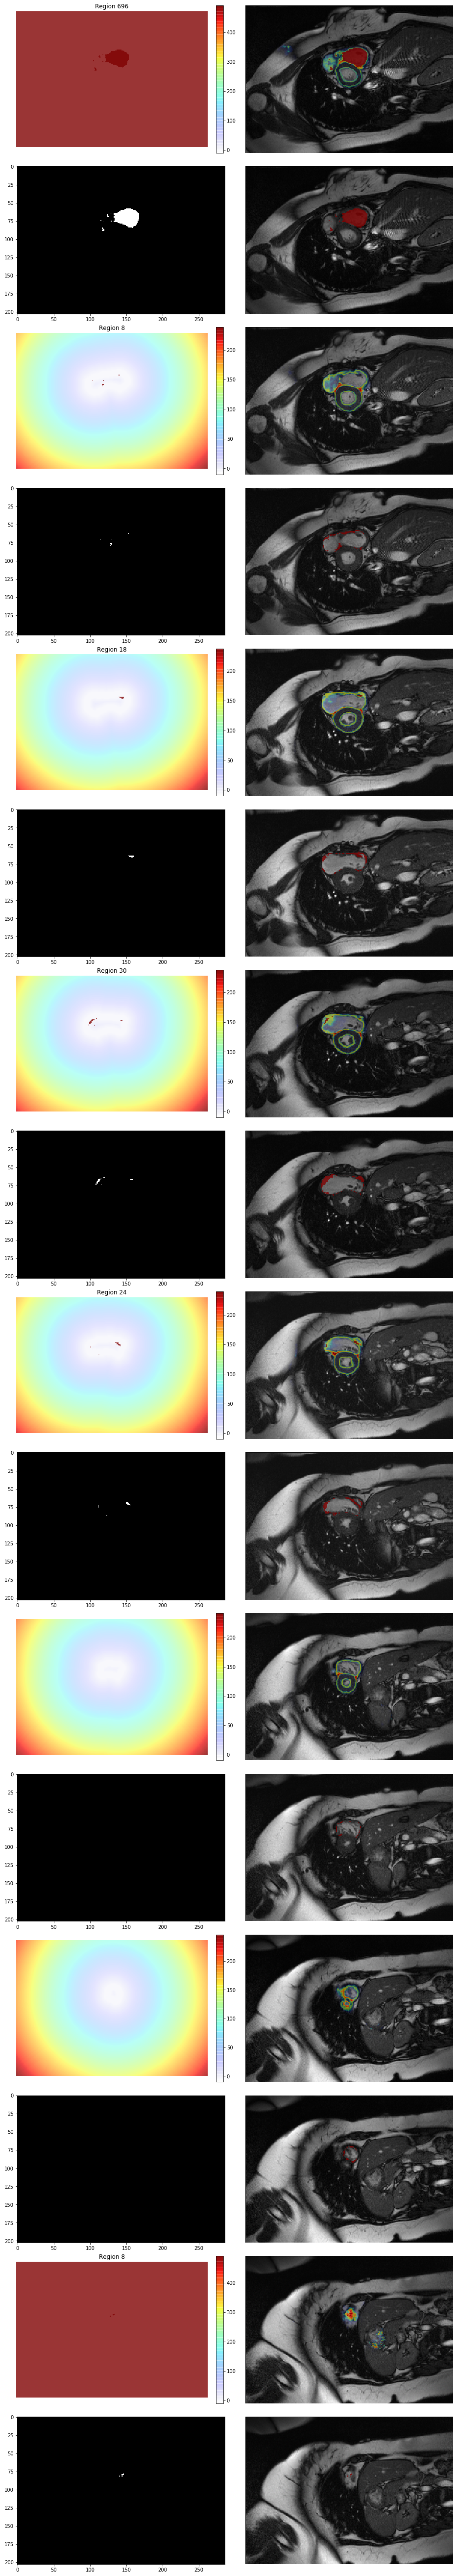

In [10]:
patient_id = "patient100"

image, labels = seg_exper_handler.test_set.get_test_pair(patient_id)

num_of_classes, w, h, batch_size = image.shape

# batch_size = 4

width = 16
height = batch_size * 12
columns = 4
rows = batch_size * 4
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

phase = 0
target_class = 1
cls_offset = phase * 4
cls_idx = cls_offset + target_class

for idx in np.arange(batch_size):
    image_with_padding = image[phase, :, :, idx]
    image_slice = ACDC2017DataSet.remove_padding(image_with_padding)
    auto_pred = seg_exper_handler.pred_labels[patient_id]
    auto_pred_slice = auto_pred[cls_idx, :, :, idx]
    if 0 != np.count_nonzero(auto_pred_slice):
        auto_pred_slice_border = auto_pred_border(auto_pred_slice)
    reference_slice = labels[cls_idx, :, :, idx]
    seg_errors_slice = reference_slice != auto_pred_slice
    umap = seg_exper_handler.entropy_maps[patient_id]
    umap_slice = umap[phase, :, :, idx]
    umap_slice_copy = copy.deepcopy(umap_slice)
    dt_slices = seg_exper_handler.get_dt_maps(patient_id)
    dt_slice = dt_slices[cls_idx, :, : , idx]
    # negative_idx = dt_slice <= 0
    # dt_slice[negative_idx] = -20
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    # ax1.imshow(image_slice, cmap=cm.gray)
    # ax1.imshow(reference_slice, cmap=mycmap)
    ax1_dt_plot = ax1.imshow(dt_slice, cmap=mycmap, vmin=-10.)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    ax2.imshow(umap_slice, cmap=mycmap)
    
    ax1.set_aspect('auto')
    fig.colorbar(ax1_dt_plot, ax=ax1, fraction=0.046, pad=0.04)
    plt.axis("off")
    
    row += 2 
    target_roi_slice = target_rois[patient_id][cls_idx, :, :, idx]
    ax3 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax3.imshow(target_roi_slice, cmap=cm.gray)
    target_roi_slice[target_roi_slice == 1] = 1
    ax1.imshow(target_roi_slice, cmap=mycmap)
    
    if 0 != np.count_nonzero(target_roi_slice):
        ax1.set_title("Region {}".format(np.count_nonzero(target_roi_slice)))
        ax2_dt_plot = ax2.imshow(target_roi_slice, cmap=mycmap)
    ax4 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax4.imshow(image_slice, cmap=cm.gray)
    ax4.imshow(seg_errors_slice, cmap=mycmap)
    umap_slice_copy[umap_slice_copy <= 0.1] = 0
    # ax4.imshow(umap_slice_copy, cmap=mycmap)
    plt.axis("off")
    row += 2

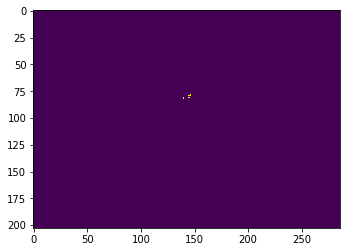

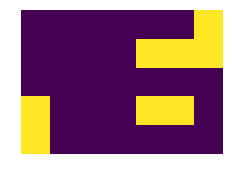

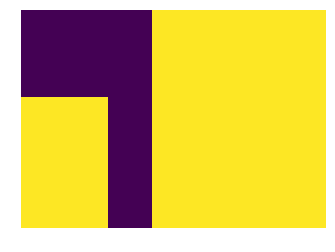

slice(78L, 83L, None)


In [12]:
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

im = target_rois[patient_id][cls_idx, :, :, -1]

plt.imshow(im)


# Now that we have only one connected component, extract it's bounding box
slice_x, slice_y = ndimage.find_objects(im==1)[0]
roi = im[slice_x, slice_y]

plt.figure(figsize=(4, 2))
plt.axes([0, 0, 1, 1])
plt.imshow(roi)
plt.axis('off')

plt.show()

struct2 = ndimage.generate_binary_structure(3, 3)
roi_after = binary_dilation(roi, structure=np.ones((3,3))).astype(roi.dtype)
# roi_after = binary_dilation(roi_after, structure=struct2).astype(roi.dtype)
plt.imshow(roi_after)
plt.axis('off')

plt.show()

print(slice_x)